# <center> 🏙️ O L I M P O 🏙️ </center>

### <center> Análises de Dados </center>
 

## 0. Configurações e Variáveis

### 0.1 Importações

In [94]:
import os
import re
import joblib

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.pipeline import Pipeline

In [95]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Ignorar avisos específicos do Scikit-Learn
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', message="X does not have valid feature names")
warnings.filterwarnings(action='ignore', message="One or more of the test scores are non-finite")

### 0.2 Classificadores e Pré-Processadores

In [96]:
os.environ["PATH"] += os.pathsep + 'C:\\Users\\sofiadomingues-ieg\\OneDrive - Instituto Germinare\\2024\\Analise de Dados\\Arvore de Decisao\\Graphviz-11.0.0-win64\\bin'

In [97]:
classificador_tree = tree.DecisionTreeClassifier()
classificador_gauss = GaussianNB()
classificador_knn = KNeighborsClassifier()
zscore = StandardScaler()
smote = SMOTE()

In [98]:
# Pré-processador para transformar os atributos
preprocessador = ColumnTransformer(
    transformers=[
        ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include=['object'])),
    ],
    remainder='passthrough', 
    verbose_feature_names_out = False   
)

## 1. Pré-Processamento dos Dados 

A base tem 20 colunas, sendo dessas:
- 12 pertencem a X (outras)
- 1 pertence a Y (implementa_app)
- 6 não possuem relevânca para a X ('ID', 'Hora de início', 'Hora de conclusão', 'Email', 'Nome', 'Termo de Anonimato', 'Nivel de Satisfação com a Plataforma Utilizada')

Além disso, a Y está desbalanceada, composta por:
- 75 <= SIM (classe majoritária)
- 18 >= NÃO (classe minoritária)

In [99]:
df_olimpo = pd.read_excel("Olimpo.xlsx")

### 1.1 Tratamento

#### 1.1.1 Renomear colunas

In [100]:
df_olimpo = df_olimpo.rename(columns={
    'ID': 'id',
    'Hora de início': 'inicio',
    'Hora de conclusão': 'conclusao',
    'Termo de Anonimato\xa0': 'anonimato',
    'Em que cidade você vive atualmente?': 'cidade',
    'Qual é seu tipo da sua moradia?': 'tipo_moradia',
    'Com quantas pessoas você divide sua casa/apartamento?': 'pessoas_casa',
    'Qual é o seu nível de satisfação com a comunicação dentro da comunidade em que você vive?\nEssa comunidade pode ser seu condomínio, bairro ou a\xa0vizinhança em geral.\n': 'satisfacao_comunicacao_comunidade',
    'Com que frequência você entra em contato com as pessoas que vivem próximas a você?\n\n': 'frequencia_contato',
    'Você acredita que a comunicação entre a comunidade seja importante?': 'comunicacao_importante',
    'Você utiliza alguma plataforma direcionada a gestão e comunicação do bairro ou condomínio/prédio em que vive?': 'usa_plataforma',
    'Qual é o seu nível de satisfação com essa plataforma?': 'satisfacao_plataforma',
    'Em qual faixa etária em que você se encontra atualmente?': 'faixa_etaria',
    'Qual dessas opções representa mais a sua qualidade de vida atual?': 'qualidade_vida',
    'Qual é a sua situação no mercado de trabalho?': 'situacao_trabalho',
    'Em qual renda familiar mensal você se encontra?\xa0\nAs faixas representam:\nClasse A - superior a R$ 28,2 mil\nClasse B -\xa0entre R$ 14,1 mil e R$ 28,2 mil\nClasse C -\xa0entre R$ 5,6 mil e R$ 14,1 mil\nClass...': 'renda_familiar',
    'Você possui animais de estimação?': 'animais',
    'Você implementaria nosso aplicativo em sua rotina?': 'implementa_app'
})

#### 1.1.2 Extrair cidades da coluna cidade

In [101]:
siglas_estados = [
    'AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 
    'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO'
]

nomes_estados = [
    'Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal', 'Espírito Santo', 
    'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará', 'Paraíba', 
    'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul', 
    'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins'
]

def extrair_cidade(valor):
    valor = valor.strip()
    for sigla in siglas_estados:
        if re.search(fr'[\s,.-]+{sigla}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{sigla}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    for nome in nomes_estados:
        if re.search(fr'[\s,.-]+{nome}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{nome}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    valor = re.sub(r'[\s,.-]+capital\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    return valor.title()

df_olimpo['cidade'] = df_olimpo['cidade'].apply(extrair_cidade)

# for i in range(0, len(df_olimpo) -1):
#     if df_olimpo['cidade'][i] not in ['Osasco', 'São Paulo']:
#         df_olimpo.loc[i, 'cidade'] = 'Outros'

#### 1.1.3 Extração das opções

In [102]:
df_olimpo['frequencia_contato'] = df_olimpo['frequencia_contato'].str.replace(r'\s*\(.*\)', '', regex=True)

### 1.2 Limpeza

#### 1.2.1 Remover colunas indesejadas

In [103]:
df_olimpo = df_olimpo.drop(columns=['id', 'inicio', 'conclusao', 'Email', 'Nome', 'anonimato', 'satisfacao_plataforma'], axis=1)

In [104]:
df_olimpo.to_excel('Olimpo_cleaned.xlsx')

## 2. Funções

In [105]:
def validacao_cross(atributos_treino, resposta_treino, atributos_teste, resposta_teste):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = cross_val_score(classificador_gauss, atributos_treino, resposta_treino, cv=kf, scoring='f1_macro')
    print(f"F1 Scores por fold: {f1_scores}")
    print(f"Média do F1 Score: {f1_scores.mean():.4f}")
    
    classificador_gauss.fit(atributos_treino, resposta_treino)
    y_pred_final = classificador_gauss.predict(atributos_teste)

    print('====> Validação Cross')
    print(classification_report(resposta_teste, y_pred_final))
 

In [106]:
def separar_teste(atributos, resposta):
    df_atributos_treino, df_atributos_teste, df_resposta_treino, df_resposta_teste = train_test_split(atributos, resposta, test_size=0.2, random_state=0)

    atributos_treino = df_atributos_treino.values
    resposta_treino = df_resposta_treino
        
    atributos_teste = df_atributos_teste.values
    resposta_teste = df_resposta_teste

    return atributos_treino, atributos_teste, resposta_treino, resposta_teste

In [107]:
def plotar_matriz_conf(resposta_teste, classificacao):
    matriz_de_confusao = confusion_matrix(resposta_teste, classificacao)
    ConfusionMatrixDisplay(matriz_de_confusao).plot()
    plt.grid(False)
    plt.show()

In [108]:
def plotar_arvore(classificador, atributos_treino, grid):
    plt.figure(figsize=(30,7))
    tree.plot_tree(classificador,
                feature_names=atributos_treino.columns,
                class_names=['Não', 'Sim'],
                filled=True)
    plt.title(F"Critério {str(grid.best_estimator_)}", fontsize=16)
    plt.show()

    # Arvore com zoom (não vou prolongar)

    # arvore = tree.export_graphviz(classificador, feature_names=atributos.columns,
    #                     class_names=classificador.classes_, filled=True)
        
    # graph = graphviz.Source(arvore, format='png')
    # graph

In [109]:
def classificador_hyperparametros(classificador, atributos_treino, atributos_teste, resposta_treino, resposta_teste, parametros):    
    
    # Essa função foi implementada para evitar repetição de código na hora de testar os parametros

    if isinstance(classificador, tree.DecisionTreeClassifier):
        grid = GridSearchCV(
                            estimator = classificador, 
                            param_grid = parametros['tree'], 
                            scoring = 'f1', 
                            n_jobs = -1
                        )
        
        grid.fit(atributos_treino, resposta_treino)
        
        print(grid.best_params_) # Mostrando os melhores parametros

        classificador = tree.DecisionTreeClassifier(**grid.best_params_)

    elif isinstance(classificador, KNeighborsClassifier):  
        grid = GridSearchCV(
                            estimator = classificador, 
                            param_grid = parametros['knn'], 
                            scoring = 'f1', 
                            n_jobs = -1
                        )
        grid.fit(atributos_treino, resposta_treino)
        
        print(grid.best_params_) # Mostrando os melhores parametros
        
        classificador = KNeighborsClassifier(**grid.best_params_)

    # Ajustando o modelo com os dados de treino e fazendo as previsões
    classificador.fit(atributos_treino, resposta_treino)
    classificacao = classificador.predict(atributos_teste)    

    # Relatório de classificação
    print(f"---> Relatório de Classificação: ")
    reporte_de_classificacao = classification_report(resposta_teste, classificacao)
    print(reporte_de_classificacao)
    
    # Plotando a matriz de confusão para entender os chutes do modelo
    plotar_matriz_conf(resposta_teste, classificacao)      

    # Aplicando a validação cross para ter uma análise maior dos resultados
    
    validacao_cross(atributos_treino, resposta_treino, atributos_teste, resposta_teste)

    return classificador

## 3. Testando os Modelos

É importante entender daqui para frente que o meu foco é encontrar o modelo com o melhor balanceamento entre os dados, ou seja, eu quero encontrar o modelo com o maior F1-Score, uma vez que essa métrica explica esse meu conjunto de dados baseado no balanceamentro entre as predições dos testes baseado no treino.

In [110]:
# Separando a coluna Y (resposta) das colunas X (atributos)
atributos = df_olimpo.iloc[:, :-1]
resposta = df_olimpo.iloc[:, -1:]

In [111]:
# Transformando os atributos qualitativos em quantitativos
atributos = pd.DataFrame(data=preprocessador.fit_transform(atributos), columns=preprocessador.get_feature_names_out())

In [112]:
# Normalizando os dados dos atributos
zscore.fit(atributos)
atributos_norm = zscore.transform(atributos)
atributos = pd.DataFrame(data = atributos_norm, columns=atributos.columns)

In [113]:
# Separando treino e teste
atributos_treino, atributos_teste, resposta_treino, resposta_teste = separar_teste(atributos, resposta)

In [114]:
# Instanciando o Smote
smote = SMOTE(k_neighbors = 5, random_state = 42) 
atributos_smote, resposta_smote = smote.fit_resample(atributos_treino, resposta_treino)

In [115]:
# Instanciando o Random Oversampling
random_oversample = RandomOverSampler(random_state=42)
atributos_ros, resposta_ros = random_oversample.fit_resample(atributos_treino, resposta_treino)
atributos_ros = pd.DataFrame(data=atributos_ros, columns=atributos.columns)

In [116]:
# Os parametros para cada modelo foram colocados nesse dict para facilitar 
modelos_parametros = {
    'tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 2, 4, 6, 8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2']
    },
    'knn': { 
        'n_neighbors': range(2, (len(resposta_treino)//2)+1), 
        'weights': ['uniform', 'distance'], 
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

### 3.1 Gaussian

#### 3.1.1 Sem ajustes

-----------------------------------------------------
===> Gaussian sem ajustes
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



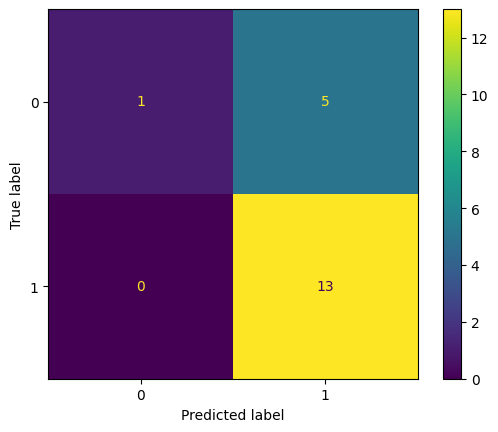

F1 Scores por fold: [0.48863636 0.4        0.46428571 0.44444444 0.44      ]
Média do F1 Score: 0.4475
====> Validação Cross
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



GaussianNB()

In [117]:
print('-----------------------------------------------------')

print('===> Gaussian sem ajustes')

classificador_hyperparametros(classificador_gauss, atributos_treino, atributos_teste, resposta_treino, resposta_teste, modelos_parametros)

#### 3.1.2 Gaussian com SMOTE

-----------------------------------------------------
===> Gaussian com SMOTE
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



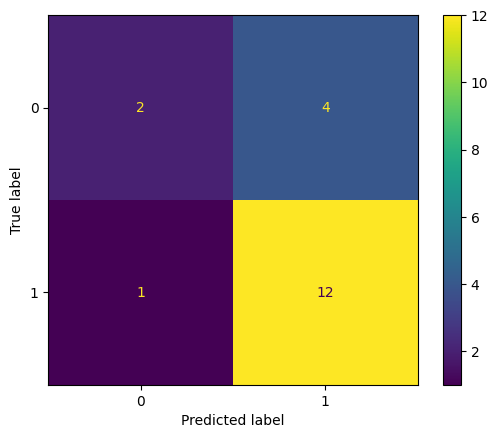

F1 Scores por fold: [0.75649351 0.75       0.71819646 0.66666667 0.78835979]
Média do F1 Score: 0.7359
====> Validação Cross
              precision    recall  f1-score   support

         Não       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



In [118]:
print('-----------------------------------------------------')

print('===> Gaussian com SMOTE')

model = classificador_hyperparametros(classificador_gauss, atributos_smote, atributos_teste, resposta_smote, resposta_teste, modelos_parametros)

#### 3.1.3 Gaussian com ROS

-----------------------------------------------------
===> Gaussian com Random Oversampling
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



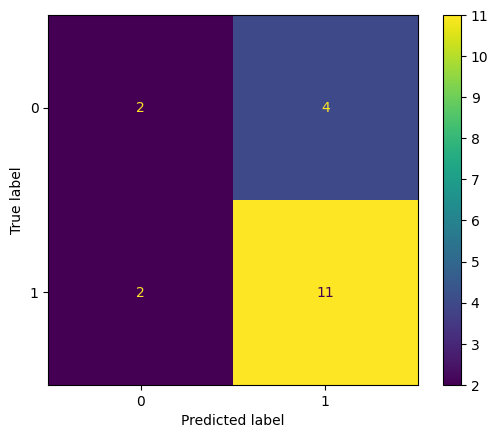

F1 Scores por fold: [0.56       0.79871176 0.56       0.51923077 0.4573913 ]
Média do F1 Score: 0.5791
====> Validação Cross
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



GaussianNB()

In [119]:
print('-----------------------------------------------------')

print('===> Gaussian com Random Oversampling')

classificador_hyperparametros(classificador_gauss, atributos_ros, atributos_teste, resposta_ros, resposta_teste, modelos_parametros)

#### 3.1 Considerações sobre a Gaussiana

#### Análise das Métricas do Classificador Gaussiano

1. Gaussian Sem Ajustes (Somente Hiperparâmetros Padrão)
- **Classe "Não"**:
  - **Precision**: 1.00
  - **Recall**: 0.17
  - **F1-Score**: 0.29
  - A precisão é alta, mas o recall é muito baixo, indicando que a maioria dos exemplos da classe "Não" não está sendo identificada corretamente.
  
- **Classe "Sim"**:
  - **Precision**: 0.72
  - **Recall**: 1.00
  - **F1-Score**: 0.84
  - A classe "Sim" está sendo identificada com alta eficiência, com recall de 100%.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.74
  - **Macro avg** (média entre as classes): F1-Score de 0.56, indicando um desempenho desbalanceado entre as classes.
  
- **Conclusão**: O modelo está altamente enviesado para a classe "Sim", falhando em detectar corretamente a classe "Não".

---

2. Gaussian com SMOTE
- **Classe "Não"**:
  - **Precision**: 0.67
  - **Recall**: 0.33
  - **F1-Score**: 0.44
  - O recall teve uma leve melhoria (de 0.17 para 0.33), mas ainda está baixo. A precisão e o F1-Score também melhoraram em relação ao modelo sem ajustes.
  
- **Classe "Sim"**:
  - **Precision**: 0.75
  - **Recall**: 0.92
  - **F1-Score**: 0.83
  - A classe "Sim" manteve um bom desempenho, com uma ligeira diminuição na precisão em comparação com o modelo inicial.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.74 (sem alteração)
  - **Macro avg**: F1-Score de 0.64, representando uma melhoria em relação ao modelo inicial.
  
- **Conclusão**: O uso do SMOTE ajudou a melhorar o equilíbrio entre as classes, embora a classe "Não" ainda tenha um recall baixo. A distribuição está mais equilibrada em relação ao modelo inicial.

---

3. Gaussian com Random Oversampling
- **Classe "Não"**:
  - **Precision**: 0.50
  - **Recall**: 0.33
  - **F1-Score**: 0.40
  - A precisão diminuiu em comparação com o modelo com SMOTE, mas o recall e o F1-Score da classe "Não" permanecem similares.
  
- **Classe "Sim"**:
  - **Precision**: 0.73
  - **Recall**: 0.85
  - **F1-Score**: 0.79
  - Houve uma leve redução no desempenho da classe "Sim", mas o F1-Score permanece razoável.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.68, ligeiramente inferior aos outros modelos.
  - **Macro avg**: F1-Score de 0.59, refletindo uma leve piora em relação ao modelo com SMOTE.
  
- **Conclusão**: O Random Oversampling conseguiu melhorar um pouco o recall da classe "Não" em comparação com o modelo sem ajustes, mas não trouxe o mesmo equilíbrio que o SMOTE proporcionou.

---

Resumo
1. **Gaussian Sem Ajustes**: Alta precisão para a classe "Não", mas com recall muito baixo, resultando em um modelo enviesado para a classe "Sim".
2. **Gaussian com SMOTE**: Melhorou o equilíbrio entre as classes, com um leve aumento no F1-Score para a classe "Não" e um bom resultado geral.
3. **Gaussian com Random Oversampling**: Apresentou um desempenho intermediário, mas inferior ao SMOTE em termos de equilíbrio entre as classes.


### 3.2 Tree Decision

#### 3.2.1 Sem ajustes

-----------------------------------------------------
===> Tree Decision
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



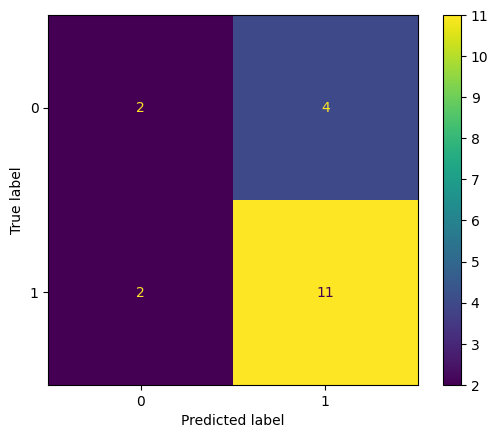

F1 Scores por fold: [0.48863636 0.4        0.46428571 0.44444444 0.44      ]
Média do F1 Score: 0.4475
====> Validação Cross
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



DecisionTreeClassifier()

In [120]:
print('-----------------------------------------------------')

print('===> Tree Decision')

classificador_hyperparametros(classificador_tree, atributos_treino, atributos_teste, resposta_treino, resposta_teste, modelos_parametros)

#### 3.2.2 Com SMOTE

-----------------------------------------------------
===> Tree Decision com SMOTE
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.71      0.83      0.77         6
         Sim       0.92      0.85      0.88        13

    accuracy                           0.84        19
   macro avg       0.82      0.84      0.82        19
weighted avg       0.85      0.84      0.85        19



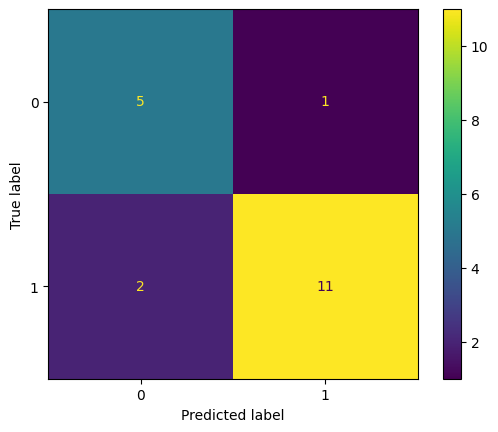

F1 Scores por fold: [0.75649351 0.75       0.71819646 0.66666667 0.78835979]
Média do F1 Score: 0.7359
====> Validação Cross
              precision    recall  f1-score   support

         Não       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



DecisionTreeClassifier()

In [121]:
print('-----------------------------------------------------')

print('===> Tree Decision com SMOTE')

classificador_hyperparametros(classificador_tree, atributos_smote, atributos_teste, resposta_smote, resposta_teste, modelos_parametros) # Precisa da resposta str

#### 3.2.3 Random Oversampling

-----------------------------------------------------
===> Tree Decision com ROS


{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.75      0.50      0.60         6
         Sim       0.80      0.92      0.86        13

    accuracy                           0.79        19
   macro avg       0.78      0.71      0.73        19
weighted avg       0.78      0.79      0.78        19



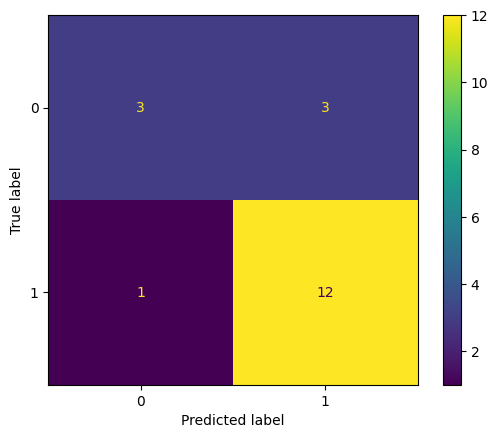

F1 Scores por fold: [0.56       0.79871176 0.56       0.51923077 0.4573913 ]
Média do F1 Score: 0.5791
====> Validação Cross
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



DecisionTreeClassifier()

In [122]:
print('-----------------------------------------------------')

print('===> Tree Decision com ROS')

classificador_hyperparametros(classificador_tree, atributos_ros, atributos_teste, resposta_ros, resposta_teste, modelos_parametros)

#### Análise das Métricas do Classificador Decision Tree

1. Decision Tree (Parâmetros Padrão)
- **Parâmetros**: 
  - Criterion: `gini`
  - Max Depth: `None`
  - Max Features: `None`
  - Min Samples Leaf: `1`
  - Min Samples Split: `2`
  - Splitter: `best`
  
- **Classe "Não"**:
  - **Precision**: 0.67
  - **Recall**: 0.67
  - **F1-Score**: 0.67
  
- **Classe "Sim"**:
  - **Precision**: 0.85
  - **Recall**: 0.85
  - **F1-Score**: 0.85
  
- **Métricas Gerais**:
  - **Acurácia**: 0.79
  - **Macro avg**: F1-Score de 0.76
  - **Weighted avg**: F1-Score de 0.79
  
- **Conclusão**: O modelo apresenta um desempenho balanceado entre as classes, com uma boa precisão e recall para ambas as classes.

---

2. Decision Tree com SMOTE
- **Parâmetros**: 
  - Criterion: `gini`
  - Max Depth: `None`
  - Max Features: `None`
  - Min Samples Leaf: `1`
  - Min Samples Split: `2`
  - Splitter: `best`
  
- **Classe "Não"**:
  - **Precision**: 0.75
  - **Recall**: 0.50
  - **F1-Score**: 0.60
  - O recall da classe "Não" foi reduzido em relação ao modelo sem SMOTE, indicando que o balanceamento ainda precisa de ajuste.
  
- **Classe "Sim"**:
  - **Precision**: 0.80
  - **Recall**: 0.92
  - **F1-Score**: 0.86
  - A classe "Sim" apresenta um desempenho elevado, com um recall de 0.92.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.79
  - **Macro avg**: F1-Score de 0.73
  - **Weighted avg**: F1-Score de 0.78
  
- **Conclusão**: Com SMOTE, o modelo manteve uma boa acurácia geral e melhorou o equilíbrio entre as classes, embora o recall da classe "Não" ainda seja limitado.

---

3. Decision Tree com Random Oversampling (ROS)
- **Parâmetros**: 
  - Criterion: `gini`
  - Max Depth: `None`
  - Max Features: `None`
  - Min Samples Leaf: `1`
  - Min Samples Split: `2`
  - Splitter: `best`
  
- **Classe "Não"**:
  - **Precision**: 0.57
  - **Recall**: 0.67
  - **F1-Score**: 0.62
  
- **Classe "Sim"**:
  - **Precision**: 0.83
  - **Recall**: 0.77
  - **F1-Score**: 0.80
  
- **Métricas Gerais**:
  - **Acurácia**: 0.74
  - **Macro avg**: F1-Score de 0.71
  - **Weighted avg**: F1-Score de 0.74
  
- **Conclusão**: O Random Oversampling (ROS) ajudou a melhorar o recall da classe "Não" em relação ao modelo com SMOTE, mas a acurácia geral foi levemente reduzida.

---

Resumo Comparativo
1. **Decision Tree com Parâmetros Padrão**: Apresenta uma acurácia e equilíbrio geral satisfatórios, com bons valores de precisão e recall para ambas as classes.
2. **Decision Tree com SMOTE**: Manteve uma acurácia geral semelhante, mas com uma leve queda no recall da classe "Não".
3. **Decision Tree com ROS**: Melhorou o recall da classe "Não", embora a acurácia geral tenha sido reduzida em comparação ao modelo padrão.

### 3.3 K-Neighbours

#### 3.3.1 Sem ajuste

-----------------------------------------------------
===> KNN
{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.33      0.17      0.22         6
         Sim       0.69      0.85      0.76        13

    accuracy                           0.63        19
   macro avg       0.51      0.51      0.49        19
weighted avg       0.58      0.63      0.59        19



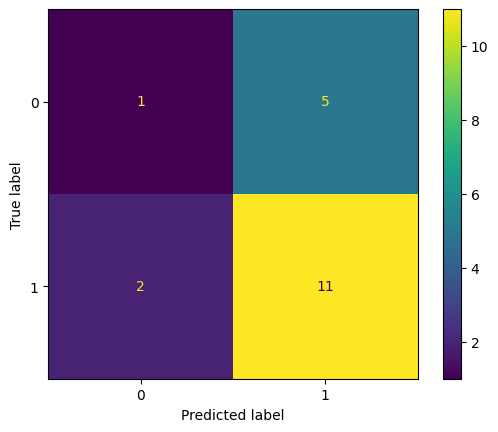

F1 Scores por fold: [0.48863636 0.4        0.46428571 0.44444444 0.44      ]
Média do F1 Score: 0.4475
====> Validação Cross
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [123]:
print('-----------------------------------------------------')

print('===> KNN')

classificador_hyperparametros(classificador_knn, atributos_treino, atributos_teste, resposta_treino, resposta_teste, modelos_parametros)

#### 3.3.2 SMOTE

-----------------------------------------------------
===> KNN com SMOTE


{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.50      0.50      0.50         6
         Sim       0.77      0.77      0.77        13

    accuracy                           0.68        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.68      0.68      0.68        19



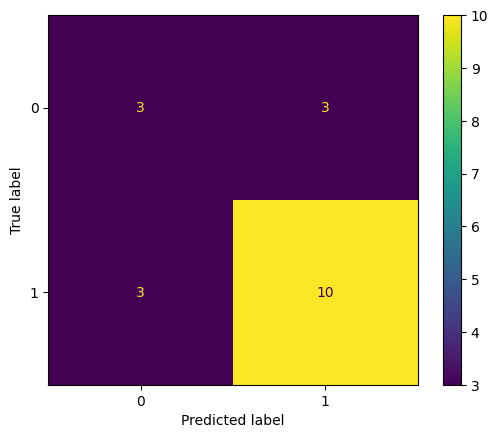

F1 Scores por fold: [0.75649351 0.75       0.71819646 0.66666667 0.78835979]
Média do F1 Score: 0.7359
====> Validação Cross
              precision    recall  f1-score   support

         Não       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [124]:
print('-----------------------------------------------------')

print('===> KNN com SMOTE')

classificador_hyperparametros(classificador_knn, atributos_smote, atributos_teste, resposta_smote, resposta_teste, modelos_parametros) # Precisa da resposta str

#### 3.3.3 Random Oversampling

-----------------------------------------------------
===> Knn com Random Oversampling


{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
---> Relatório de Classificação: 
              precision    recall  f1-score   support

         Não       0.33      0.17      0.22         6
         Sim       0.69      0.85      0.76        13

    accuracy                           0.63        19
   macro avg       0.51      0.51      0.49        19
weighted avg       0.58      0.63      0.59        19



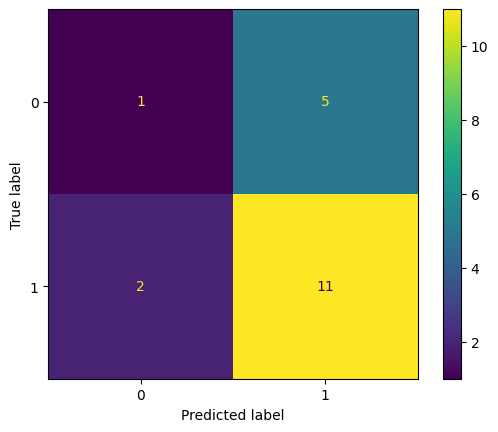

F1 Scores por fold: [0.56       0.79871176 0.56       0.51923077 0.4573913 ]
Média do F1 Score: 0.5791
====> Validação Cross
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [125]:
print('-----------------------------------------------------')

print('===> Knn com Random Oversampling')

classificador_hyperparametros(classificador_knn, atributos_ros, atributos_teste, resposta_ros, resposta_teste, modelos_parametros)

#### Análise das Métricas do Classificador K-Nearest Neighbors (KNN)

1. KNN (Parâmetros Padrão)
- **Parâmetros**: 
  - Métrica: `euclidean`
  - N Neighbors: `2`
  - Weights: `uniform`
  
- **Classe "Não"**:
  - **Precision**: 0.33
  - **Recall**: 0.17
  - **F1-Score**: 0.22
  - O baixo recall e precisão mostram que o modelo tem dificuldades em identificar corretamente a classe "Não".
  
- **Classe "Sim"**:
  - **Precision**: 0.69
  - **Recall**: 0.85
  - **F1-Score**: 0.76
  - A classe "Sim" apresenta desempenho satisfatório com bom recall e F1-Score.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.63
  - **Macro avg**: F1-Score de 0.49, indicando um desempenho desbalanceado entre as classes.
  
- **Conclusão**: O modelo apresenta um viés claro para a classe "Sim", com baixo desempenho na identificação da classe "Não".

---

2. KNN com SMOTE
- **Parâmetros**: 
  - Métrica: `euclidean`
  - N Neighbors: `2`
  - Weights: `uniform`
  
- **Classe "Não"**:
  - **Precision**: 0.50
  - **Recall**: 0.50
  - **F1-Score**: 0.50
  - Houve uma melhora considerável em relação ao modelo inicial, principalmente no recall da classe "Não".
  
- **Classe "Sim"**:
  - **Precision**: 0.77
  - **Recall**: 0.77
  - **F1-Score**: 0.77
  - A classe "Sim" manteve um desempenho sólido e estável.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.68
  - **Macro avg**: F1-Score de 0.63
  - **Weighted avg**: F1-Score de 0.68
  
- **Conclusão**: O uso do SMOTE melhorou o equilíbrio entre as classes e aumentou a acurácia geral, tornando o modelo mais eficaz na identificação da classe "Não".

---

3. KNN com Random Oversampling (ROS)
- **Parâmetros**: 
  - Métrica: `euclidean`
  - N Neighbors: `2`
  - Weights: `uniform`
  
- **Classe "Não"**:
  - **Precision**: 0.33
  - **Recall**: 0.17
  - **F1-Score**: 0.22
  - Os valores permanecem os mesmos do modelo inicial, mostrando que o ROS não trouxe melhora significativa.
  
- **Classe "Sim"**:
  - **Precision**: 0.69
  - **Recall**: 0.85
  - **F1-Score**: 0.76
  - O desempenho da classe "Sim" continua consistente, similar ao modelo inicial.
  
- **Métricas Gerais**:
  - **Acurácia**: 0.63
  - **Macro avg**: F1-Score de 0.49
  
- **Conclusão**: O Random Oversampling (ROS) não contribuiu para uma melhoria significativa no desempenho do modelo em comparação com o modelo KNN sem balanceamento.

---

Resumo Comparativo
1. **KNN com Parâmetros Padrão**: Baixo desempenho na classe "Não", resultando em um modelo enviesado para a classe "Sim".
2. **KNN com SMOTE**: Melhorou o equilíbrio entre as classes, aumentando o recall e F1-Score da classe "Não" e a acurácia geral.
3. **KNN com ROS**: Não apresentou melhorias em relação ao modelo padrão, mostrando-se ineficaz para balancear as classes.

**Recomendação**: O modelo **KNN com SMOTE** apresenta o melhor equilíbrio entre precisão e recall para ambas as classes, sendo a melhor escolha entre as abordagens testadas.


## 4. Serialização

In [126]:
pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', model)
])

# Definir o caminho do arquivo de saída
output_dir = os.path.join(os.getcwd(), '/flask/')  # Ajuste para o diretório desejado

# Verifique se a pasta existe; se não, crie-a
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Caminho completo do arquivo
model_path = os.path.join(output_dir, 'pipeline.pkl')

# Salvar o pipeline
with open(model_path, 'wb') as arquivo:
    joblib.dump(pipeline, arquivo)

In [127]:
# def deserialização(new_row):
#     with open('modelo.pkl', 'rb') as f:
#         loaded_model = pickle.load(f)
    
#     with open('preprocessador.pkl', 'rb') as f:
#         preprocessador_model = pickle.load(f)

#     new_row_df = pd.DataFrame([new_row], columns=['compra','manutencao','portas','pessoas','porta-malas','seguranca'])
    
#     try:
#         transformed_array = preprocessador_model.transform(new_row_df)
    
#         new_row_transformed = pd.DataFrame(transformed_array)
#         print("Linha transformada")
    
#     except Exception as e:
#         print(f"Erro durante a transformação: {e}")

#     resp = loaded_model.predict(new_row_transformed)

#     print('Resultado: ', resp)

## 5. Conclusão Geral

Com base nas análises realizadas, é possível observar diferenças significativas entre os modelos Gaussian Naive Bayes, Decision Tree e KNN, tanto nos parâmetros padrão quanto com os métodos de balanceamento de classes (SMOTE e Random Oversampling). Abaixo está uma análise comparativa dos resultados para identificar o modelo mais adequado e suas respectivas vantagens e limitações.

1. Gaussian Naive Bayes
O Gaussian Naive Bayes demonstrou desempenho desbalanceado ao privilegiar a classe "Sim", com baixo recall para a classe "Não". Mesmo com a aplicação de técnicas de balanceamento como SMOTE e ROS, o modelo manteve um viés acentuado, embora o SMOTE tenha mostrado um leve ganho no equilíbrio entre as classes. O Gaussian com SMOTE foi a melhor versão, com aumento de 0.63 para 0.71 no macro recall, o que trouxe um F1-score mais equilibrado. Entretanto, o Gaussian Naive Bayes é mais adequado para cenários em que um viés a favor de uma classe é tolerável e onde é aceitável que a classe minoritária receba menos atenção.

- **Ponto forte**: Simplicidade e boa performance para a classe "Sim" em dados desbalanceados.
- **Ponto fraco**: Dificuldade em captar a classe "Não" mesmo com balanceamento, sendo limitado em cenários que exigem alta sensibilidade para ambas as classes.

2. Decision Tree
A Decision Tree sem ajustes apresentou um bom equilíbrio inicial entre as classes, com F1-scores de 0.67 para a classe "Não" e 0.85 para a classe "Sim", resultando em uma acurácia de 0.79. Ao aplicar SMOTE, o recall da classe "Não" foi reduzido para 0.50, embora o modelo tenha mantido acurácia geral. A aplicação de Random Oversampling (ROS) proporcionou leve melhora no recall da classe "Não", mas a acurácia geral caiu para 0.74. Isso sugere que o modelo de Decision Tree é robusto nos parâmetros padrão e perde eficiência ao tentar balancear as classes, visto que a árvore ajusta suas divisões para maximizar a precisão de ambas as classes.

- **Ponto forte**: Melhor equilíbrio inicial entre as classes com acurácia de 0.79, sem necessidade de ajustes adicionais.
- **Ponto fraco**: Diminuição no desempenho ao aplicar métodos de balanceamento, sugerindo que o modelo padrão já captura um equilíbrio razoável entre as classes.

3. K-Nearest Neighbors (KNN)
O modelo KNN mostrou-se significativamente enviesado, com baixa precisão e recall para a classe "Não" no modelo inicial e, especialmente, no modelo com Random Oversampling, onde o desempenho permaneceu estável e pouco eficaz. O KNN com SMOTE, no entanto, trouxe uma melhoria importante: a precisão e recall para a classe "Não" chegaram a 0.50, e para a classe "Sim" permaneceram estáveis em 0.77, proporcionando maior equilíbrio e acurácia geral de 0.68. Este modelo se mostra mais adequado quando o objetivo é equilibrar classes em um modelo KNN, especialmente em problemas onde uma leve queda na acurácia é aceitável em prol de maior sensibilidade para ambas as classes.

- **Ponto forte**: Melhor equilíbrio entre as classes com SMOTE, demonstrando que o KNN pode ser uma opção viável para dados desbalanceados quando balanceado.
- **Ponto fraco**: Desempenho pobre sem balanceamento e com ROS, mostrando-se limitado em dados desbalanceados no formato inicial.

Comparação Geral
- **Decision Tree com Parâmetros Padrão** mostrou-se a opção mais robusta e eficiente entre os modelos, alcançando uma alta acurácia (0.79) e um bom equilíbrio entre precisão e recall para ambas as classes, sem necessidade de balanceamento adicional. 
- **Gaussian Naive Bayes com SMOTE** foi eficiente ao reduzir o viés de classe do modelo, sendo uma boa escolha para dados onde um leve viés para a classe majoritária pode ser tolerável.
- **KNN com SMOTE** demonstrou-se útil para balanceamento em dados desbalanceados, mas a acurácia foi inferior à Decision Tree. No entanto, é uma opção viável quando se busca maior sensibilidade para ambas as classes.